In [1]:
import pickle

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch_optimizer as optim

import os
import glob
import multiprocessing as mp
import pefile

from tqdm.notebook import tqdm
from src.model import Network
from pathlib import Path

from sklearn.feature_extraction import FeatureHasher
from sklearn.model_selection import StratifiedKFold as KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [4]:
def read_json(path):
    with open(path, "r") as f:
        return json.load(f)
    
def load_pickle(path):
    with open(path, "rb") as f:
        return pickle.load(f)
    
def dump_pickle(vector, path):
    with open(path, "wb") as f:
        pickle.dump(vector, f)

def get_label_table(path):
    table = dict()
    with open(path, "r") as f:
        for line in f.readlines()[1:]:
            md5, label = line.strip().split(",")
            table[md5] = int(label)
    return table

def iat_embedding(functions):
    if len(functions) < MAX_LEN:
        functions += ["<pad>"] * (MAX_LEN - len(functions))
    else:
        functions = functions[:MAX_LEN]
    
    
    embedded_vector = []
    for function in functions:
        if function in word_to_index:
            index = word_to_index[function]
        else:
            index = word_to_index["<unk>"]
            
        embedded_vector.append(embedding_table[index])
    return np.array(embedded_vector)

def load_vectors(base_path):
    vectors, labels = [], []
    for path in tqdm(glob.glob(base_path)):
        md5 = os.path.basename(path)[:-4]+'.vir'
        if md5 in label_table:
            vectors.append(load_pickle(path))
            labels.append(label_table[md5])
    return np.array(vectors), np.array(labels)

def load_iat_with_processing(base_path):
    vectors, labels = [], []
    for path in tqdm(glob.glob(base_path)):
        md5 = os.path.basename(path)[:-4] +'.vir'
        if md5 in label_table:
            vectors.append(iat_embedding(load_pickle(path)))
            labels.append(int(label_table[md5]))
    return np.array(vectors), np.array(labels)


word_to_index = load_pickle("word_to_index.pkl")
index_to_word = load_pickle("index_to_word.pkl")

In [5]:
MAX_LEN = 2510
class ApiDataset(Dataset):
    def __init__(self, data_path):
        self.X, self.y = load_iat_with_processing(data_path)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        item = dict()
        item["input"] = torch.from_numpy(self.X[idx])
        item["target"] = torch.Tensor([self.y[idx]]).type(torch.long)
        return item
        
label_table = get_label_table("label.csv")
embedding_table = torch.load("Pretrained_Apicall_Vector_100.pkl")

dataset = DataLoader(ApiDataset("data/api_sequence_deduplicated/*"), batch_size=4, shuffle=True)

In [7]:
from tqdm.notebook import trange
import sys

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

loss_function = nn.CrossEntropyLoss()
net = Network(input_shape=MAX_LEN)
optimizer = optim.RAdam(net.parameters(),  lr = 0.001)
# early_stopping = EarlyStopping(patience=5, min_percent_gain=1)

n_epochs = 20
epochs = trange(n_epochs, desc="training")
best = {"loss": sys.float_info.max}

net = net.to(device)
total_loss = []
for epoch in epochs:
    losses = []
    for batch in dataset:
        net.zero_grad()
        input_data, target_data = batch["input"], batch["target"]
        input_data = input_data.to(device)
        target_data = target_data.to(device)

        output = net(input_data)
        loss = loss_function(output, target_data)
        loss.backward()
        optimizer.step()
        iter_loss = loss.item()
        losses.append(iter_loss)
    epoch_loss = np.mean(losses)
    total_loss.append(epoch_loss)
    print("Loss: ", epoch_loss)
    epochs.set_postfix_str(f"loss: {epoch_loss:.6f}")
    if epoch_loss < best["loss"]:
        best["state"] = net.state_dict()
        best["loss"] = epoch_loss
        best["epoch"] = epoch + 1


cuda


Loss:  3.919131479321333
Loss:  3.8785401190526585
Loss:  3.878525061537863
Loss:  3.8785244422635685
Loss:  3.878524388183339
Loss:  3.8785243427734892
Loss:  3.878524306742494
Loss:  3.8785243288738918
Loss:  3.8785243083956016
Loss:  3.8785243371394293
Loss:  3.878524341322803
Loss:  3.8785243037061745
Loss:  3.878524303773648
Loss:  3.8785243054604925
Loss:  3.878524303503753
Loss:  3.878524304988176
Loss:  3.878524303739911
Loss:  3.878524304144754
Loss:  3.87852430353749
Loss:  3.878524318550405



([<matplotlib.axis.XTick at 0x2be3bba6508>,
 <a list of 20 Text xticklabel objects>)

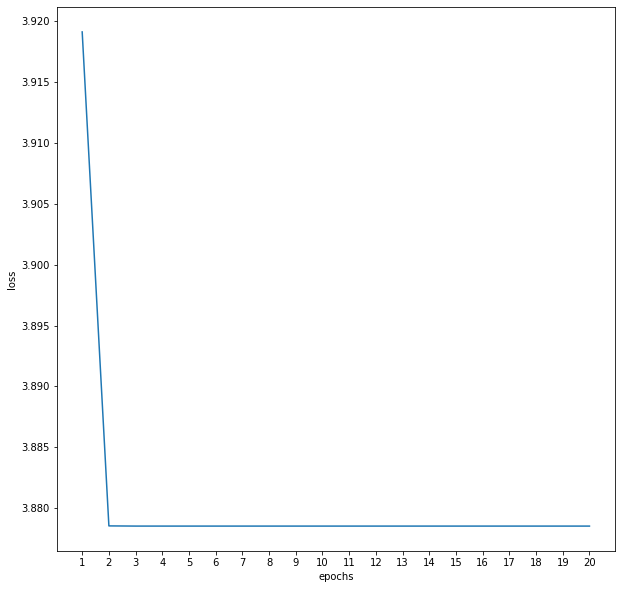

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

index = np.arange(n_epochs)
plt.figure(figsize=(10, 10))
plt.plot(index, total_loss)
plt.xlabel("epochs")
plt.ylabel("loss")
plt.xticks(index, [i for i in range(1, n_epochs+1)])